In [1]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import chi2, poisson, uniform, norm
from IPython.display import clear_output
import estimator
seednumber=2024
dt = 6.0
R = np.diag([1.0, 1e-4, 1e-4]) # в рад задается
plt.rcParams['figure.figsize'] = [10, 6]
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

In [2]:
class Target():
    """
    target model description
    """
    def __init__(self, seed = 2024):
        self.targetState = {                                   # state vector
            'x':0.0,'vx':0.0,'ax':0.0, # x states
            'y':0.0,'vy':0.0,'ay':0.0, # y states
            'z':0.0,'vz':0.0,'az':0.0, # z states
            'w':0.0} # angle velocity

        self.rand_gen = np.random.default_rng(seed)           # set seed for random numbers
        
    def init_state(self,state):
        initKeys = state.keys()                               # init targetState components
        for k in initKeys:
            self.targetState[k] = state[k]                    # set values with same keys
    
    
    def CV(self):
        # move target with CV model due dt
        keys = ['x','vx','y','vy','z','vz']
        X = [self.targetState[i] for i in keys]
        F = [[1.0,  dt,     0.0,    0.0,   0.0,  0.0],
             [0.0,  1.0,    0.0,    0.0,   0.0,  0.0],
             [0.0,  0.0,    1.0,    dt,    0.0,  0.0],
             [0.0,  0.0,    0.0,    1.0,   0.0,  0.0],
             [0.0,  0.0,    0.0,    0.0,   1.0,   dt],
             [0.0,  0.0,    0.0,    0.0,   0.0,  1.0]]
        G = [[dt**2/2,  0.0,         0.0],
             [dt,       0.0,         0.0],
             [0.0,      dt**2/2,     0.0],
             [0.0,      dt,          0.0],
             [0.0,      0.0,     dt**2/2],
             [0.0,      0.0,     dt     ]]
        
    
        Xe = np.matmul(F,X)#+np.matmul(G,w)

        for (i,k) in enumerate(keys):
            self.targetState[k] = Xe[i]
        return {k:self.targetState[k] for k in self.targetState.keys()} # return new dictionary

    def CA(self):
        # move target with CA model due dt
        keys = ['x','vx','ax','y','vy','ay','z','vz','az']
        X = [self.targetState[i] for i in keys]
        F = [[1.0,  dt,     dt**2/2,  0.0,    0.0,    0.0,     0.0,    0.0,       0.0],
             [0.0,  1.0,    dt,       0.0,    0.0,    0.0,     0.0,    0.0,       0.0],
             [0.0,  0.0,    1.0,      0.0,    0.0,    0.0,     0.0,    0.0,       0.0],
             [0.0,  0.0,    0.0,      1.0,    dt,     dt**2/2, 0.0,    0.0,       0.0],
             [0.0,  0.0,    0.0,      0.0,    1.0,    dt,      0.0,    0.0,       0.0],
             [0.0,  0.0,    0.0,      0.0,    0.0,    1.0,     0.0,    0.0,       0.0],
             [0.0,  0.0,    0.0,      0.0,    0.0,    0.0,     1.0,    dt,    dt**2/2],
             [0.0,  0.0,    0.0,      0.0,    0.0,    0.0,     0.0,    1.0,        dt],
             [0.0,  0.0,    0.0,      0.0,    0.0,    0.0,     0.0,    0.0,       1.0]]
        
        G = [[dt**2/2,  0.0,         0.0],
             [dt,       0.0,         0.0],
             [1.0,      0.0,         0.0],
             [0.0,      dt**2/2,     0.0],
             [0.0,      dt,          0.0],
             [0.0,      1.0,         0.0],
             [0.0,      0.0,     dt**2/2],
             [0.0,      0.0,          dt],
             [0.0,      0.0,         1.0]]
        
        #w = self.rand_gen.normal([0.0,0.0], [self.processNoise['ax'],self.processNoise['ay']])
        Xe = np.matmul(F,X)#+np.matmul(G,w)

        for (i,k) in enumerate(keys):
            self.targetState[k] = Xe[i]
        # return new dictionary
        return {k:self.targetState[k] for k in self.targetState.keys()}

In [3]:
# ИНИЦИАЛИЗАЦИЯ МОДЕЛИ ДВИЖЕНИЯ
tg1 = Target(2024)
tg1.init_state({'x':50.0,'y':0.0,'z':20.0, 'vx':200.0,'vy':0.0,'vz':0.0}) # к ключам добавить ax и ay будет модель CA
#tg1.init_process_noise({'ax':0.0,'ay':0.0}) # при нулях ax и ay воздействия на цель не будет. будет прямая траектория.

In [4]:
def plot_xy(tg1, Pd = 1.0, xmk=[], ymk=[]): #при pd = 1 пропусков не будет
    n = 20 # количество измерении

    x1=[];y1=[];z1=[]; vx1=[];vy1=[];vz1=[] 
    for i in range(n):
        state1 = tg1.CV()
        if uniform.rvs() > (1 - Pd):
            x1.append(state1['x'])
            y1.append(state1['y'])
            z1.append(state1['z'])
            vx1.append(state1['vx'])
            vy1.append(state1['vy'])
            vz1.append(state1['vz'])

    X_true_data = np.array([x1,vx1,y1,vy1,z1,vz1])        

    # print("X_true_data", X_true_data)
    plt.figure()
    plt.plot(X_true_data[0], X_true_data[2], 'x')
    plt.title('X  Y')
    
    plt.figure()
    plt.plot(X_true_data[0], X_true_data[4], 'gx')
    plt.title('X  Z')
   
    plt.show()

    # Создаем трехмерный scatter plot для массива
    scatter1 = go.Scatter3d(x=X_true_data[0], y=X_true_data[2], z=X_true_data[4], mode='markers+lines', marker=dict(size=3, color='blue'), name='X_true_data')
    fig.add_trace(scatter1)

    # Обновляем параметры макета
    fig.update_layout(scene=dict(aspectmode="cube"))
    fig.show()

    return (x1,y1,z1,X_true_data)

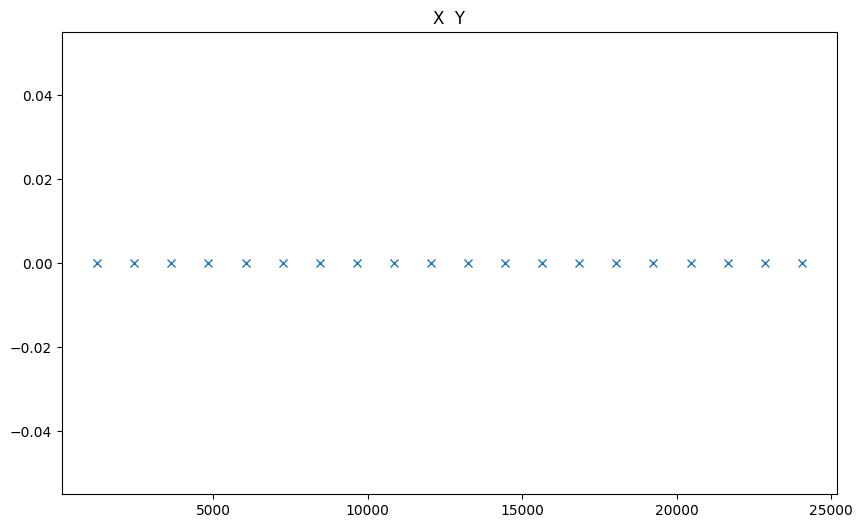

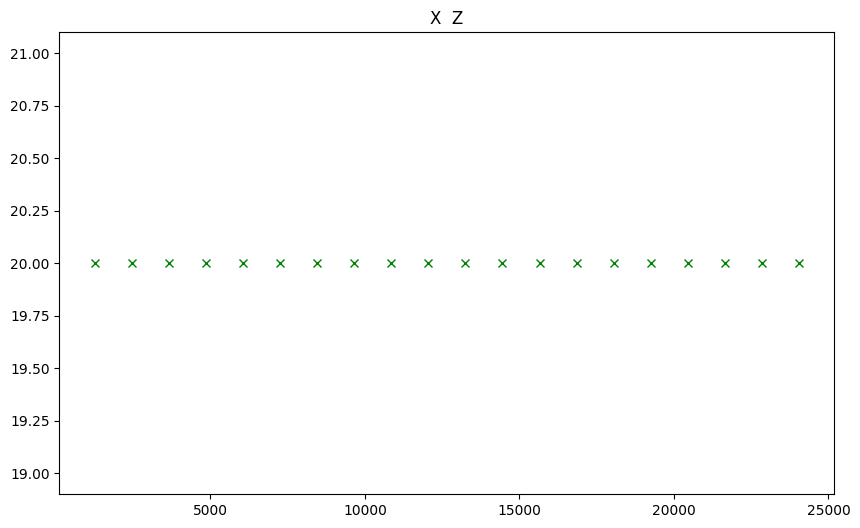

In [5]:
x,y,z, X_true_data = plot_xy(tg1,1)


In [6]:
r = np.sqrt(np.array(x)**2 + np.array(y)**2 + np.array(z)**2)
az = np.arctan2(np.array(y),np.array(x)) # Азимут
um = np.arctan2(np.array(z),np.sqrt(np.array(x)**2+np.array(y)**2)) # Угол места


In [7]:
process_var = 0.5
Qp = np.diag([process_var, process_var, process_var])
G = np.array([[dt**2/2,  0.0,         0.0],
             [dt,       0.0,          0.0],
             [0.0,      dt**2/2,      0.0],
             [0.0,      dt,           0.0],
             [0.0,      0.0,      dt**2/2],
             [0.0,      0.0,      dt     ]])
Q = G@Qp@G.T

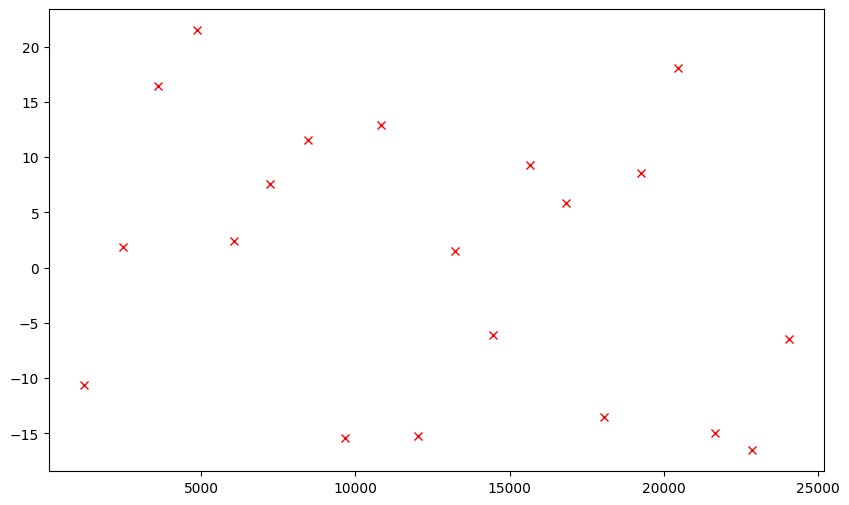

In [8]:
def add_process_noise(X, Var):
    X_true_plus_noise = X + np.sqrt(Var) @ np.random.normal(loc=0, scale=1.0, size=(X.shape[0], X.shape[1]))
    return X_true_plus_noise
X_true_plus_noise = add_process_noise(X_true_data, Q)
plt.plot(X_true_plus_noise[0],X_true_plus_noise[2],"rx")
# print("X_true+noise", X_true_plus_noise)

In [9]:

r_true_with_noise = np.sqrt(np.array(X_true_plus_noise[0])**2 + np.array(X_true_plus_noise[2])**2 + np.array(X_true_plus_noise[4])**2)
az_true_with_noise = np.arctan2(np.array(X_true_plus_noise[2]),np.array(X_true_plus_noise[0])) # Азимут
um_true_with_noise = np.arctan2(np.array(X_true_plus_noise[4]),np.sqrt(np.array(X_true_plus_noise[0])**2+np.array(X_true_plus_noise[2])**2)) # Угол места


In [10]:
def do_measurement(X,R):
    Zm = np.zeros((R.shape[0], X.shape[1]))
    for i in range(Zm.shape[1]):
        Zm[0,i] = r_true_with_noise[i]
        Zm[1,i] = az_true_with_noise[i]
        Zm[2,i] = um_true_with_noise[i]
    # print ("zm=", Zm)
    Z_plus_noise = Zm + np.sqrt(R) @ np.random.normal(loc=0, scale=math.sqrt(1.0), size=(Zm.shape[0], Zm.shape[1]))
    return Z_plus_noise
Z = do_measurement (X_true_plus_noise,R)
# print ("Z=", Z)
for i in range(Z.shape[1]):
    x = Z[0] * np.cos(Z[1]) * np.cos(Z[2])
    y = Z[0] * np.sin(Z[1]) * np.cos(Z[2])
    z = Z[0] * np.sin(Z[2])
Z_cart = np.vstack((x,y,z))


In [11]:
def estimate (Z):
    ukf = estimator.BindUkf()

    X_c = np.zeros((6, 1))
    for i in range (Z.shape[1]-1):
        if i == 0:
            X = [[Z[0,0] * np.cos(Z[1,0]) * np.cos(Z[2,0])], [0.], [Z[0,0] * np.sin(Z[1,0]) * np.cos(Z[2,0])],[0.], [Z[0,0] * np.sin(Z[2,0])],[0.]] # инициализируем вектор состояния, равный первому измерению
            X_c = X
        _ = ukf.predictUkf(X)
        X = ukf.correctUkf(Z[:,i+1])
        X_c = np.hstack((X_c, X))
    # print("\nX_correct", X_c)
    return X_c  
X_c = estimate(Z)


U =     2.64876           0           0           0           0           0
          0     26.4575           0           0           0           0
 -0.0256938           0     4.21664           0           0           0
          0           0           0     26.4575           0           0
  -0.154413           0 -0.00155411           0     4.21514           0
          0           0           0           0           0     26.4575

U =     35.9981           0           0           0           0           0
    11.2497     2.03264           0           0           0           0
   -0.17974    0.464644     46.0846           0           0           0
 -0.0299319   0.0764477     11.7798     3.89767           0           0
   -1.15608     2.98846  -0.0385375   0.0412963     45.9818           0
  -0.192522    0.492085 -0.00636161  0.00679831     11.7722     3.88764

U =     33.871          0          0          0          0          0
   11.2019    1.07748          0          0          0 

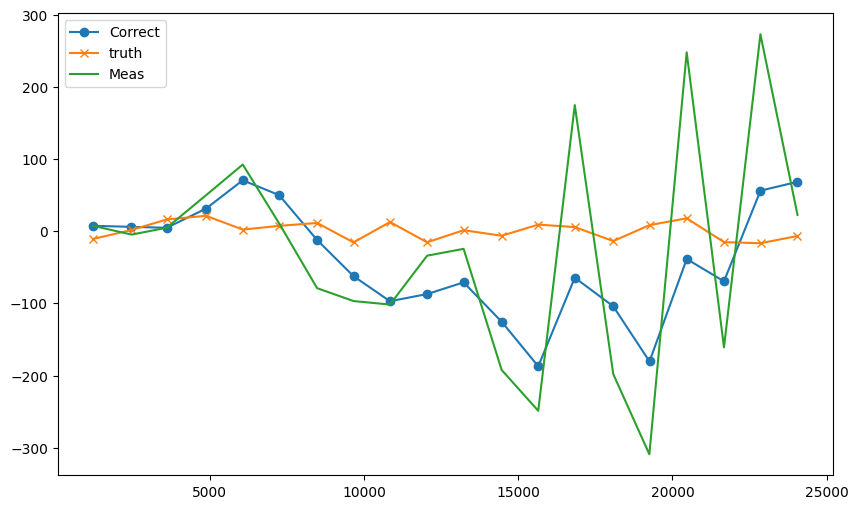

In [12]:
plt.figure()
plt.plot(X_c[0],X_c[2], label='Correct', marker='o')
plt.plot(X_true_plus_noise[0],X_true_plus_noise[2], label='truth', marker='x')
plt.plot(Z_cart[0],Z_cart[1], label='Meas')
plt.legend()


 67%|██████▋   | 8/12 [00:00<00:00, 41.03it/s]


U =    2.64794          0          0          0          0          0
         0    26.4575          0          0          0          0
 0.0589676          0     4.2203          0          0          0
         0          0          0    26.4575          0          0
 -0.120125          0 0.00276759          0    4.21999          0
         0          0          0          0          0    26.4575

U =    35.9883          0          0          0          0          0
   11.2495    2.02892          0          0          0          0
  0.411816   -1.06682    46.0926          0          0          0
 0.0685793  -0.175521    11.7804     3.8985          0          0
 -0.898099    2.32647  0.0688003 -0.0737011    46.0438          0
  -0.14956   0.383077  0.0113571 -0.0121328    11.7768    3.89377

U =    33.8781          0          0          0          0          0
   11.2012     1.0871          0          0          0          0
   0.52822    -4.2097    82.5396          0          0       

100%|██████████| 12/12 [00:00<00:00, 43.41it/s]



U =      2.64594            0            0            0            0            0
           0      26.4575            0            0            0            0
  -0.0310197            0      4.22046            0            0            0
           0            0            0      26.4575            0            0
  -0.0233906            0 -0.000283229            0      4.22061            0
           0            0            0            0            0      26.4575

U =      35.975           0           0           0           0           0
    11.2493     2.02378           0           0           0           0
  -0.216544    0.562598      46.102           0           0           0
 -0.0360608   0.0925634     11.7811     3.89942           0           0
  -0.174949    0.454515 -0.00707634  0.00757717     46.1038           0
 -0.0291343   0.0748418 -0.00116811  0.00124739     11.7812     3.89959

U =    33.8621          0          0          0          0          0
   11.2038    1.055

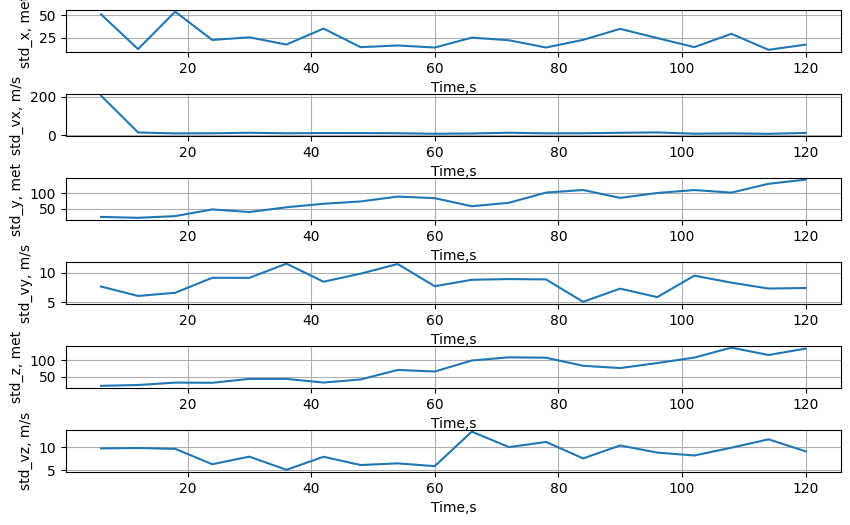

In [13]:
def calc_err(X):
    Xn = add_process_noise(X, Q)
    Zn = do_measurement(Xn, R)
    X_c = estimate(Zn)
    err = X_c  - Xn
    return err

from tqdm import tqdm

def calc_std_err(X):
    num_iterations = 12
    var_err = np.zeros((X.shape[0], X.shape[1]))

    for i in tqdm(range(num_iterations)):
        err = calc_err(X)
        var_err += err ** 2

    var_err /= num_iterations
    return np.sqrt(var_err)

std_err = calc_std_err(X_true_data)

plt.figure()
plt.subplot(6, 1, 1)
plt.plot((np.arange(len(std_err[0, :]))+1)*dt, std_err[0, :].T)
plt.xlabel('Time,s')
plt.ylabel('std_x, met')
plt.grid(True)
plt.subplot(6, 1, 2)
plt.plot((np.arange(len(std_err[1, :]))+1)*dt, std_err[1, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_vx, m/s')
plt.subplot(6, 1, 3)
plt.plot((np.arange(len(std_err[2, :]))+1)*dt, std_err[2, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_y, met')
plt.subplot(6, 1, 4)
plt.plot((np.arange(len(std_err[3, :]))+1)*dt, std_err[3, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_vy, m/s')
plt.subplot(6, 1, 5)
plt.plot((np.arange(len(std_err[4, :]))+1)*dt, std_err[4, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_z, met')
plt.subplot(6, 1, 6)
plt.plot((np.arange(len(std_err[5, :]))+1)*dt, std_err[5, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_vz, m/s')
plt.subplots_adjust(wspace=12.0, hspace=1.0)
plt.show()